In [1]:
import yt.wrapper as yt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind
import os

from tqdm.auto import tqdm


%matplotlib inline

In [2]:
yt.config["proxy"]["url"] = 'hahn.yt.yandex.net'
client = yt.YtClient(proxy='hahn', token=os.environ.get('YT_TOKEN'))

In [42]:
table = '//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_uniform_len'

In [50]:
def plot_agreement(table, session_len_column = "session_len_new"):
    read_result = pd.DataFrame(client.read_table(table, raw=False))
    read_result["three_of_three"] = read_result["probability"] >= 0.9
    read_result["two_of_three"] = (read_result["probability"] < 0.9) & (read_result["probability"] > 0.5)
    read_result["one_of_three"] = read_result["probability"] < 0.5

    read_result["session_len_new"] = read_result["session_len"].apply(lambda x: x if x < 15 else 16)
    
    parsed_data = read_result.groupby(by=["session_len_new"]).agg(
                                                    three_of_three = pd.NamedAgg(column = 'three_of_three', aggfunc = 'sum'),
                                                    two_of_three = pd.NamedAgg(column = 'two_of_three', aggfunc = 'sum'),
                                                    one_of_three = pd.NamedAgg(column = 'one_of_three', aggfunc = 'sum'),
                                                    ).reset_index()
    parsed_data["agreement"] = (parsed_data["three_of_three"] * 3 + 2 * parsed_data["two_of_three"] + parsed_data["one_of_three"]) \
    / (parsed_data["three_of_three"] + parsed_data["two_of_three"] + parsed_data["one_of_three"])

    cnt_error = 1

    parsed_data["agreement_std"] =  parsed_data["agreement"] * (
        6 * cnt_error / (parsed_data["three_of_three"] * 3 + 2 * parsed_data["two_of_three"] + parsed_data["one_of_three"]) + 
        cnt_error / (parsed_data["three_of_three"] + parsed_data["two_of_three"] + parsed_data["one_of_three"])
    )
    
    plt.figure(figsize=(10, 10))
    plt.title("Согласованость Асессоров в зависимости от длинны сессии")
    plt.plot(parsed_data["session_len_new"], parsed_data["agreement"], label = "средняя согласованность")
    plt.legend()
    plt.fill_between(parsed_data["session_len_new"], parsed_data["agreement"] - 3 * parsed_data["agreement_std"], parsed_data["agreement"] + 3 * parsed_data["agreement_std"], alpha = 0.3)
    plt.xlabel("Длинна сессии")
    plt.ylabel("Средняя согласованность")
    plt.show()

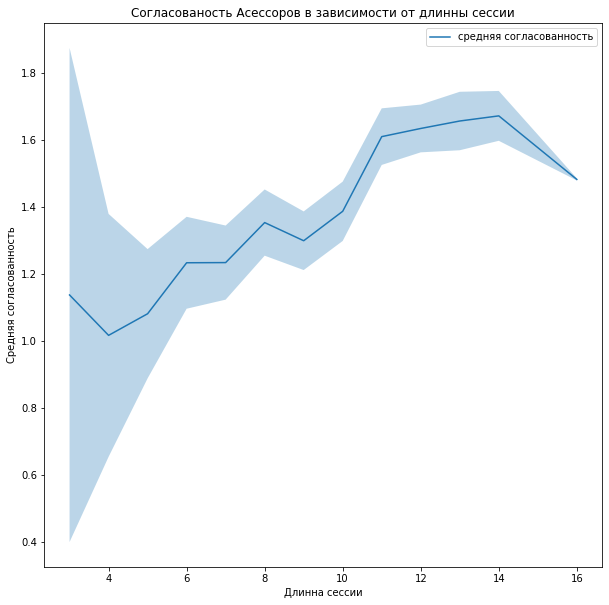

In [51]:
plot_agreement('//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_uniform_len')

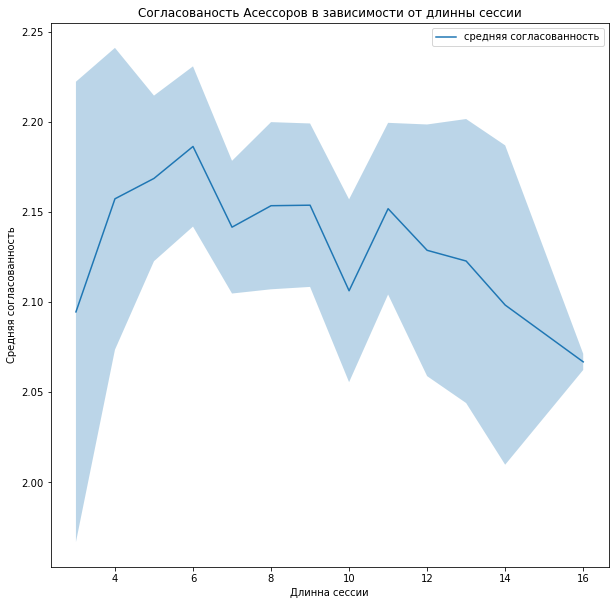

In [52]:
plot_agreement('//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_random_len')